In [1]:
'''
In this section one defines environment variables. 
Because I used this notebook on number of machines, I implemented class especially for this. 
You may not needed in one and use just simple definitions.
'''

from system_variables import SystemVariables

# choose system according your current machine
# SYSTEM_NAME = "Windows"
# SYSTEM_NAME = "Colab"
# SYSTEM_NAME = "Kaggle"
SYSTEM_NAME = "Linux"

sv = SystemVariables(SYSTEM_NAME)
PROJECT_FOLDER = sv.get_project_folder()
SRC_FOLDER = sv.get_src_folder()
OUTPUT_FOLDER = sv.get_output_folder()
TUAB_DIRECTORY, TUAB_TRAIN, TUAB_EVAL = sv.get_TUAB_folders()
DEPR_ANON_DIRECTORY = sv.get_depr_anon_folder()
INHOUSE_DIRECTORY = sv.get_inhouse_folder()

print(SYSTEM_NAME)
print()

print(f"{PROJECT_FOLDER = }")
print(f"{SRC_FOLDER = }")
print(f"{OUTPUT_FOLDER = }")
print()

print(f"{TUAB_DIRECTORY = }")
print(f"{TUAB_TRAIN = }")
print(f"{TUAB_EVAL = }")
print()

print(f"{DEPR_ANON_DIRECTORY = }")
print()

print(f"{INHOUSE_DIRECTORY = }")
print()

Linux

PROJECT_FOLDER = ''
SRC_FOLDER = ''
OUTPUT_FOLDER = ''

TUAB_DIRECTORY = 'Data/TUAB/'
TUAB_TRAIN = 'Data/TUAB/train/normal/01_tcp_ar/'
TUAB_EVAL = 'Data/TUAB/eval/normal/01_tcp_ar/'

DEPR_ANON_DIRECTORY = 'Data/depression_anonymized/'

INHOUSE_DIRECTORY = 'Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/'



In [2]:
import warnings
warnings.simplefilter("ignore")

import os
import sys
import pickle
import json
import random
from IPython.display import display, clear_output

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

from tqdm.auto import tqdm as tqdm_auto

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import wandb
!wandb login 1b8e8dc9dcf1a34397a04197c4826d3fe7441dae

import mne

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
cuda


In [3]:
sys.path.append(SRC_FOLDER)

%load_ext autoreload
%autoreload 1
%aimport utils, models, training

from utils import SEED
from utils.models_evaluation import evaluateClassifier, evaluateRegressor, evaluateClassifier_inner_outer_cv
from utils.data_reading import DataReader
from utils.plotting import dataset_hists, plotData, dict_to_df
from utils.dataset import InMemoryDataset
from utils.logger import Logger

from models.modules import encoder_conv, decoder_conv, encoder_conv4, decoder_conv4
from models.VAE import VAE, BetaVAE_H, BetaVAE_B
from models.AE import AE, AE_framework
from models.UNet import UNet

from training import train_eval

# Data load


### TUAB

In [4]:
# from sklearn.model_selection import train_test_split

# chunks_train = np.load(TUAB_TRAIN + "chunks_fz_cz_pz_3x124.npy").reshape(-1, 1, 3, 124)
# targets_train = np.load(TUAB_TRAIN + "targets.npy")
# chunks_val_test = np.load(TUAB_EVAL + "chunks_fz_cz_pz_3x124.npy").reshape(-1, 1, 3, 124)
# targets_val_test = np.load(TUAB_EVAL + "targets.npy")
# chunks_val, chunks_test, targets_val, targets_test = train_test_split(chunks_val_test, targets_val_test, test_size=0.5, random_state=SEED, shuffle=False)
# print(chunks_train.shape, targets_train.shape, chunks_val.shape, targets_val.shape, chunks_test.shape, targets_test.shape)

### Depression anonimyzed

In [5]:
file = DEPR_ANON_DIRECTORY + "dataset_128_10.0.pkl"
train_set, val_set, test_set = DataReader(file).split()
chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]


Chunks shape: (3, 1280) , length: 1068 , keys: dict_keys(['chunk', 'target', 'patient'])
N patients = 178
Train=142, validation=18, test=18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1068/1068 [00:00<00:00, 30311.45it/s]

Train: 852 (3, 1280)
Validation: 108 (3, 1280)
Test: 108 (3, 1280)


### Inhouse dataset

In [6]:
# with open(INHOUSE_DIRECTORY + "dataset.pkl", "rb") as f:
#     chunks_list = pickle.load(f)
# print("\nChunks shape:", chunks_list[0]["chunk"].shape, "length:", len(chunks_list), "keys:", chunks_list[0].keys())

In [7]:
# from sklearn.model_selection import train_test_split
# from copy import deepcopy

# patients_targets = pd.DataFrame.from_records([{"patient": x["patient"], "target": x["target"]} for x in chunks_list]).drop_duplicates().reset_index(drop=True)
# print(f"N patients = {len(patients_targets)}")

# patients_train, patients_val_test = train_test_split(patients_targets, test_size=0.2, random_state=SEED, stratify=patients_targets["target"], shuffle=True)
# patients_val, patients_test = train_test_split(patients_val_test, test_size=0.5, random_state=SEED, stratify=patients_val_test["target"], shuffle=True)
# patients_train, patients_val, patients_test = patients_train["patient"].values, patients_val["patient"].values, patients_test["patient"].values
# print(f"Train={len(patients_train)}, validation={len(patients_val)}, test={len(patients_test)}")

# reset = {"chunk": [], "target": [], "patient": []}
# train_set, val_set, test_set = deepcopy(reset), deepcopy(reset), deepcopy(reset)

# for chunk in tqdm_auto(chunks_list):
#     patient_id = chunk["patient"]
#     was_added = False
#     for data_set, patients in zip([train_set, val_set, test_set], [patients_train, patients_val, patients_test]):
#         if patient_id in patients:
#             for tag in ["chunk", "target", "patient"]:
#                 data_set[tag].append(chunk[tag])
#                 was_added = True
        
#     if not was_added:
#         raise ValueError(f"Unexpected patient id {patient_id}")
    
# for data_set in [train_set, val_set, test_set]:
#     data_set["chunk"] = np.array(data_set["chunk"])
#     data_set["target"] = np.array(data_set["target"])

# print("Train:", len(train_set["chunk"]), train_set["chunk"][0].shape)
# print("Valitation:", len(val_set["chunk"]), val_set["chunk"][0].shape)
# print("Test:", len(test_set["chunk"]), test_set["chunk"][0].shape)

In [8]:
# chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
# targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]

#### For training on healthy only

In [9]:
# chunks_train_0 = chunks_train[np.where(targets_train == 0)]
# targets_train_0 = np.zeros(len(chunks_train_0))

# chunks_train = chunks_train_0
# targets_train = targets_train_0

## Dataset preparation

In [10]:
data_config = {
    "batch_size": 256,
    "num_workers": 0,
    "samples_shape": chunks_train[0].shape,
    "n_train_samples": len(chunks_train),
    "n_validation_samples": len(chunks_val),
    "n_test_samples": len(chunks_test),
    "minmax": "across_whole_sample",
    "record_part": "10 s",
    "task": "MDD classification",
    "dataset": "depression anonymized" #!!! CHECK BEFORE TRAINING
}

Train dataset: 852
Val dataset: 108
Test dataset: 108
Train dataloader: 4
Val dataloader: 1
Test dataloader: 1
Train sample shape: torch.Size([3, 1280])
Val sample shape: torch.Size([3, 1280])
Test sample shape: torch.Size([3, 1280])
Train sample type: torch.FloatTensor
Val sample type: torch.FloatTensor
Test sample type: torch.FloatTensor


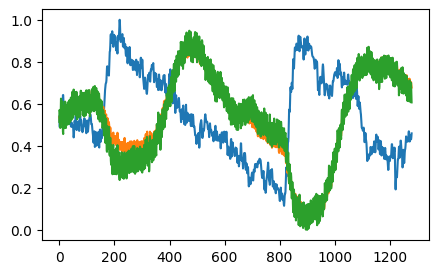

In [11]:
t_max=None
train_dataset = InMemoryDataset(chunks_train, is_squeeze=False, is_unsqueeze=False, t_max=t_max)
val_dataset = InMemoryDataset(chunks_val, is_squeeze=False, is_unsqueeze=False, t_max=t_max)
test_dataset = InMemoryDataset(chunks_test, is_squeeze=False, is_unsqueeze=False, t_max=t_max)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=data_config['batch_size'], num_workers=data_config['num_workers'])
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=data_config['batch_size'], num_workers=data_config['num_workers'])
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=data_config['batch_size'], num_workers=data_config['num_workers'])

print("Train dataset:", len(train_dataset))
print("Val dataset:", len(val_dataset))
print("Test dataset:", len(test_dataset))

print("Train dataloader:", len(train_dataloader))
print("Val dataloader:", len(val_dataloader))
print("Test dataloader:", len(test_dataloader))

print("Train sample shape:", train_dataset[0].shape)
print("Val sample shape:", val_dataset[0].shape)
print("Test sample shape:", test_dataset[0].shape)

print("Train sample type:", train_dataset[0].type())
print("Val sample type:", val_dataset[0].type())
print("Test sample type:", test_dataset[0].type())

plt.figure(figsize=(5,3))
plt.plot(train_dataset[0].squeeze().T)
plt.show()

# Evaluation

wandb:   40 of 40 files downloaded.  


No logging
Model is in evaluation mode
Epoch 0, step 0
Plotting PCA...


,Explained variance,Ratio
0,0.028293,0.590115
1,0.014324,0.298759


Plotting reconstruction...


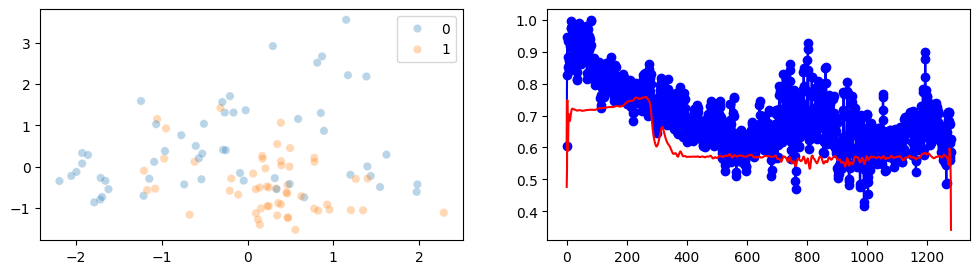

Classifier/regressor metrics evaluation...
Data split
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Evaluation on the train data
Evaluation on the test data
GridSearchCV
Evaluation on the train data
Evaluation on the test data


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import Ridge

model_description="depr. anon., AE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid"
model_config = {
    "input_dim": train_dataset[0].shape,
}
model = AE(
    n_channels=train_dataset[0].shape[-2],
    n_classes=train_dataset[0].shape[-2]
).to(device)

run = wandb.init()
artifact = run.use_artifact('dmitriykornilov_team/EEG_age_prediction/AE:v18', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir + '/50_epoch.pth'))

logger = Logger(
    log_type="none", #"wandb"/"tensorboard"/"none"
    model=model,
)

ml_config = {
    "ml_model" : Pipeline([('scaler', StandardScaler()), ('clf', SVC())]),
    "ml_param_grid" : {
        'clf__kernel': ['linear'],
        'clf__C': np.logspace(-1, 1, 3),
        'clf__probability': [True],
        'clf__class_weight': ['balanced'],
        'clf__random_state': [SEED]
    },
    "ml_eval_function" : [evaluateClassifier, evaluateClassifier_inner_outer_cv],
    "ml_eval_function_tag" : ["d", "cv"],
    "ml_eval_function_kwargs" : [
        {
            "verbose" : 1,
            "test_size" : 0.33,
            "SEED" : SEED,
            "cv_scorer" : accuracy_score,
            "metrics" : [(average_precision_score, "soft"), (roc_auc_score, "soft"), (accuracy_score, "hard"), (f1_score, "hard")],
            "metrics_for_CI" : [(average_precision_score, "soft"), (roc_auc_score, "soft"), (accuracy_score, "hard"), (f1_score, "hard")],
            "n_bootstraps" : 1000
        },
        {
            "verbose" : 1,
            "SEED" : SEED,
            "cv_scorer" : accuracy_score,
            "metrics" : [(average_precision_score, "soft"), (roc_auc_score, "soft"), (accuracy_score, "hard"), (f1_score, "hard")],
            "n_splits" : 10,
        }
    ],
    "ml_metric_prefix" : "clf",
    
    # ml_model=Pipeline([('scaler', StandardScaler()), ('reg', Ridge())]),
    # ml_param_grid={
    #     'reg__alpha': np.logspace(-2, 2, 5),
    #     # 'reg__solver': ['sag'],
    #     # 'reg__tol': [1e-4]
    # },
    # ml_eval_function=evaluateRegressor,
    # ml_metric_names=["mse_test", "mse_train"],
    # ml_metric_prefix="reg",
}

model, results = train_eval(
    val_dataloader,
    model,
    device=device,
    mode="test",
    test_dataset=val_dataset,
    targets_test=targets_val,
    check_period=1e10,
    plot_period=1e10,
    logger=logger,
    avg_embeddings_over_time=True,
    plot_type="classification", #"regression"/"classification",
    **ml_config,
    # step_max=1,
)

run.finish()

In [15]:
dict_to_df(results)

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv
0,847.445,0.779,0.500,7.169,847.445,11.936,11.324,5.204,0.733,0.815,0.750,0.743,0.750,0.158,0.759,0.162,0.678,0.137,0.678,0.144,0.743,0.757,0.845,0.885,0.861,0.865,0.856,0.184,0.857,0.181,0.831,0.149,0.834,0.161,0.842,0.882,0.877,0.188,0.867,0.157,0.807,0.168,0.807,0.179,0.870,0.122,0.843,0.129,0.734,0.197,0.740,0.199


In [ ]:
# import wandb
# api = wandb.Api()
# run = api.run("dmitriykornilov_team/EEG_age_prediction/")

# for k in results:
#     run.summary["test." + k] = results[k]
# run.summary.update()